# Flowing with JAX (Part 1)

2020, [@glouppe](https://twitter.com/glouppe).

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/glouppe/anaconda3/envs/jax"

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as np 
from jax import grad, jacfwd, random, vmap
from jax.scipy.stats import multivariate_normal
rng = random.PRNGKey(0)

# Affine transformation

Let us start with a good old Normal variable $\mathbf{z} \sim \mathcal{N}(\mu=0, \Sigma=\mathbb{1})$.

In [3]:
z = random.normal(rng, (2,))

We define $\mathbf{x}$ as the affine transformation $\mathbf{x} = g^{-1}(\mathbf{z}) = A \mathbf{z} + \mathbf{b}$. The transformation is invertible and we have $\mathbf{z} = g(\mathbf{x}) = A^{-1} (\mathbf{x} - \mathbf{b})$.

In [4]:
# x = g_inv(z) = Az + b
A = np.array([[0.75, -0.3],  
              [-0.7, 1.25]])
b = np.array([1.0, 0.5])

def g_inv(z, A=A, b=b):
    return A @ z + b

# z = g(x) = A^-1 (x - b)
A_inv = np.linalg.inv(A)

def g(x, A_inv=A_inv, b=b):
    return A_inv @ (x - b)

In [5]:
print("z =", z)
x = g_inv(z)
print("x = g_inv(z) =", x)
z_rec = g(x)
print("z_rec = g(x) =", z_rec)

z = [-0.78476596  0.85644484]
x = g_inv(z) = [0.15449208 2.1198921 ]
z_rec = g(x) = [-0.78476596  0.8564448 ]


The transformation and its inverse are defined on a per-sample level, but can be easily vectorized using JAX's `vmap`:

In [6]:
vg_inv = vmap(g_inv)
vg = vmap(g)

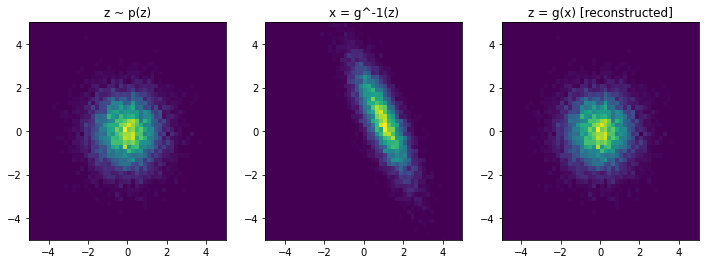

In [7]:
z = random.normal(rng, (10000, 2))

x = vg_inv(z)
z_rec = vg(x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist2d(z[:, 0], z[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_title("z ~ p(z)")

ax2.hist2d(x[:, 0], x[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_title("x = g^-1(z)")

ax3.hist2d(z_rec[:, 0], z_rec[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
ax3.set_title("z = g(x) [reconstructed]")

plt.show()

The original $\mathbf{z}$ values are properly reconstructed from $\mathbf{x}$. So far so good!

# Change of variables theorem

For $\mathbf{x} = g^{-1}(\mathbf{z})$ with $\mathbf{z} \sim p(\mathbf{z})$, we have
$$p(\mathbf{x}) = p(g(\mathbf{x})) \left| \text{det} J_{g(\mathbf{x})} \right|,$$
where the Jacobian $J_{g(\mathbf{x})} = \frac{\partial g(\mathbf{x})}{\partial \mathbf{x}}$.

In [8]:
z = random.normal(rng, (2,))
x = g_inv(z)

mu_z = np.zeros(2)
cov_z = np.eye(2)

print("log p(z) =", multivariate_normal.logpdf(z, mean=mu_z, cov=cov_z))

J = jacfwd(g)
print("log p(x) =", multivariate_normal.logpdf(g(x), mean=mu_z, cov=cov_z) + 
                    np.log(np.abs(np.linalg.det(J(x)))))

log p(z) = -2.5125546
log p(x) = -2.1944134


Since we consider an affine transformation of the normal $\mathbf{z} \sim \mathcal{N}(\mu=0, \Sigma=\mathbb{1})$, we also know that $p(\mathbf{x}) = \mathcal{N}(g^{-1}(\mu), A \Sigma A^T)).$

In [9]:
print("log p(x) =", multivariate_normal.logpdf(x, mean=g_inv(mu_z), cov=A @ cov_z @ A.T))

log p(x) = -2.1944134


Hence, our expression for the density based on the change of variables theorem seems to hold!

Again, we can use `vmap` to vectorize the evaluation of the density for batches of samples:

In [10]:
vJ = vmap(J)
vdet = vmap(np.linalg.det)

z = random.normal(rng, (5, 2))
x = vg_inv(z)

print("log p(x) =", multivariate_normal.logpdf(vg(x), mean=np.zeros(2), cov=np.eye(2)) + 
                    np.log(np.abs(vdet(vJ(x)))))
print("log p(x) =", multivariate_normal.logpdf(x, mean=g_inv(mu_z), cov=A @ cov_z @ A.T))

log p(x) = [-1.623878  -1.8078455 -1.6282433 -1.9196538 -1.948336 ]
log p(x) = [-1.6238781 -1.8078456 -1.6282433 -1.9196539 -1.9483361]


# Parameter estimation

Given observations $\mathbf{x}$ and assuming the affine transformation $\mathbf{z} = g(\mathbf{x}) = A^{-1} (\mathbf{x} - \mathbf{b})$, the parameters $A^{-1}$ and $\mathbf{b}$ can be estimated by maximizing the likelihood $p(\mathbf{x} | A^{-1}, \mathbf{b})$.

Let us start with some training data $\mathbf{x} \sim p(\mathbf{x})$.

In [11]:
z_train = random.normal(rng, (10000, 2))
x_train = vg_inv(z_train)

Then we define $-\log p(\mathbf{x} | A^-1, \mathbf{b})$ as our loss function, which we express using the change of variables theorem.

In [12]:
def g(x, A_inv, b):             # xxx: must redefine those, since vmap does not support kw args :(
    return A_inv @ (x - b)

vg = vmap(g, (0, None, None))
J = jacfwd(g)
vJ = vmap(J, (0, None, None))
vdet = vmap(np.linalg.det)

def loss(A_inv, b, batch):
    return -np.mean(multivariate_normal.logpdf(vg(batch, A_inv, b), 
                                               mean=np.zeros(2), 
                                               cov=np.eye(2)) + 
                    np.log(np.abs(vdet(vJ(batch, A_inv, b)))))

Since JAX supports automatic differentiation, we can readily obtain its gradient with respect to 1st ($A^{-1}$) and 2nd ($\mathbf{b}$) argument using `grad`:

In [13]:
grad_loss = grad(loss, (0, 1))

Hence making it straightfoward estimate $A^{-1}$ and $\mathbf{b}$ using gradient descent:

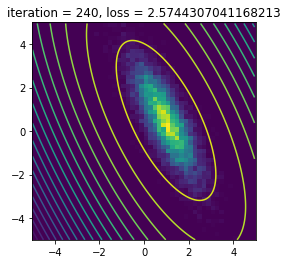

In [14]:
# Gradient descent
A_inv_est = np.eye(2) + random.normal(rng, (2, 2)) * 0.01
b_est = random.normal(rng, (2,)) * 0.01

lr = 0.01

for i in range(250):
    grad_A_inv, grad_b = grad_loss(A_inv_est, b_est, x_train)
    A_inv_est -= lr * grad_A_inv 
    b_est -= lr * grad_b
    
    # Show progress
    if i % 10 == 0:
        clear_output(wait=True)
        
        plt.figure(figsize=(4, 4))
        plt.title("iteration = {}, loss = {}".format(i, loss(A_inv_est, b_est, x_train)))
        
        plt.hist2d(x_train[:, 0], x_train[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)

        x = np.arange(-5.0, 5.0, 0.05)
        y = np.arange(-5.0, 5.0, 0.05)
        X, Y = np.meshgrid(x, y)
        shape = X.shape
        batch = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
        Z = multivariate_normal.logpdf(vg(batch, A_inv_est, b_est), 
                                       mean=np.zeros(2), 
                                       cov=np.eye(2)) + np.log(np.abs(vdet(vJ(batch, A_inv_est, b_est))))
        Z = Z.reshape(shape)
        CS = plt.contour(X, Y, Z, levels=20)

        plt.show()

Of course, in this case, fitting the parameters of an affine transformation of a Normal distribution by expressing the data likelihood through the change of variables theorem is clearly an overkill. 

However, the same recipe holds for any invertible transformation $\mathbf{z} = g(\mathbf{x})$. In particular, parameterizing $g$ with an invertible neural network will result in a Normalizing Flow (stay tuned for Part 2!).